In [1]:
import csv
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow.models.rnn import rnn  
from tensorflow.models.rnn.rnn_cell import BasicLSTMCell, LSTMCell    
import collections
import re
import cPickle as pickle

urlFinder = re.compile('\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*')
atNameFinder = re.compile(r'@([A-Za-z0-9_]+)')
atNameCounter = 0

exclude_punc = set([
        "!",
        "?",
        ".",
        ",",
        ":",
        ";",
        "'",
        "\"",
        "“",
        "’",
        "-"
])


words = []

with open('data.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        for word in row[1] \
            .strip() \
            .replace("&amp;", "") \
            .replace("&gt;","") \
            .replace("&lt;", "") \
            .lower().split():
            
            if urlFinder.match(word):
                words.append("<URL/>")
            elif atNameFinder.search(word):
                words.append("<AT_NAME_%s/>" % atNameCounter)
                atNameCounter +=1
            else:
                word = ''.join(ch for ch in word if ch not in exclude_punc)
                words.append(word)

    
#words = filter(None, (' '.join(bag)).split())
vocabulary_size = int(round(len(set(words)),-2))-100

print("Vocabulary Size: %s" % vocabulary_size)


Vocabulary Size: 11500


In [2]:
count = [['UNK', -1]]
count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
dictionary = dict()
for word, _ in count:
    dictionary[word] = len(dictionary)
data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0  # dictionary['UNK']
        unk_count += 1
    data.append(index)
count[0][1] = unk_count
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])


('Most common words (+UNK)', [['UNK', 55], ('<URL/>', 2913), ('the', 2386), ('to', 2144), ('a', 1333)])
('Sample data', [11, 15, 266, 161, 191, 64, 4, 365, 1, 110])


In [3]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
        while target in targets_to_avoid:
            target = random.randint(0, span - 1)
        targets_to_avoid.append(target)
        batch[i * num_skips + j] = buffer[skip_window]
        labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=10, num_skips=10, skip_window=5)

for i in range(10):
    print(batch[i], '->', labels[i, 0])
    print(reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i, 0]])


# In[4]:

batch_size = 20
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 10       # How many words to consider left and right.
num_skips = 20         # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(np.arange(valid_window), valid_size))
num_sampled = 64    # Number of negative examples to sample.

(64, '->', 191)
('its', '->', 'core')
(64, '->', 161)
('its', '->', 'common')
(64, '->', 4)
('its', '->', 'a')
(64, '->', 110)
('its', '->', '#makeamericagreatagain')
(64, '->', 105)
('its', '->', '#trump2016')
(64, '->', 1)
('its', '->', '<URL/>')
(64, '->', 365)
('its', '->', 'disaster')
(64, '->', 266)
('its', '->', 'end')
(64, '->', 15)
('its', '->', 'will')
(64, '->', 11)
('its', '->', 'i')


In [4]:
graph = tf.Graph()
with graph.as_default():
    # Input da 4ta.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        # Construct the variables for the NCE loss
        with tf.name_scope("nce_weights") as scope:
            nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                    stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        nce_biases_hist = tf.histogram_summary("nce_biases", nce_biases)
        
    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    with tf.name_scope("loss") as scope:
        loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                         num_sampled, vocabulary_size))
    # Construct the SGD optimizer using a learning rate of 1.0.
    with tf.name_scope("train") as scope:
        optimizer = tf.train.GradientDescentOptimizer(0.25).minimize(loss)
        
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
    valid_embeddings, normalized_embeddings, transpose_b=True)
    



In [5]:
# Step 5: Begin training.
num_steps = 100001
with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    merged = tf.merge_all_summaries()
    writer = tf.train.SummaryWriter("/tmp/tensor_logs/expiriment_1", session.graph_def)
    
    #Adds an op to initialize all variables
    init_op = tf.initialize_all_variables()
    
    # Begins running the init opp
    init_op.run()
    
    print("Initialized")
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}
        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        summary_str, _, loss_val = session.run([merged, optimizer, loss], feed_dict=feed_dict)
        writer.add_summary(summary_str, step)
        average_loss += loss_val
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 5000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
            for k in xrange(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = "%s %s," % (log_str, close_word)
            print(log_str)

    final_embeddings = normalized_embeddings.eval()
    
    # save final embeddings for Expiriment #2
    with open("word_embeddings.pkl", "wb") as f:
        pickle.dump(final_embeddings, f)
    with open("word_mappings.pkl", "wb") as f:
        pickle.dump(reverse_dictionary, f)


Initialized
('Average loss at step ', 0, ': ', 233.20170593261719)
Nearest to do: <AT_NAME_2601/>, 5th, crossed, sticker, oped, scary, #southcarolinaprimary, primaries,
('Average loss at step ', 2000, ': ', 102.98079307556152)
('Average loss at step ', 4000, ': ', 54.832165327548978)
Nearest to do: <AT_NAME_1325/>, sees, nafta, power, 5th, coincidence, careful, free,
('Average loss at step ', 6000, ': ', 35.893567650794985)
('Average loss at step ', 8000, ': ', 31.924694279193879)
('Average loss at step ', 10000, ': ', 31.299419360160826)
Nearest to do: sees, <AT_NAME_1325/>, 5th, consistently, in, to, spoke, nafta,
('Average loss at step ', 12000, ': ', 21.905777438879014)
('Average loss at step ', 14000, ': ', 26.707835393667221)
Nearest to do: sees, in, to, <AT_NAME_1325/>, and, revolution, 5th, coincidence,
('Average loss at step ', 16000, ': ', 20.761946350097656)
('Average loss at step ', 18000, ': ', 19.734143357515336)
('Average loss at step ', 20000, ': ', 23.181363344192505)


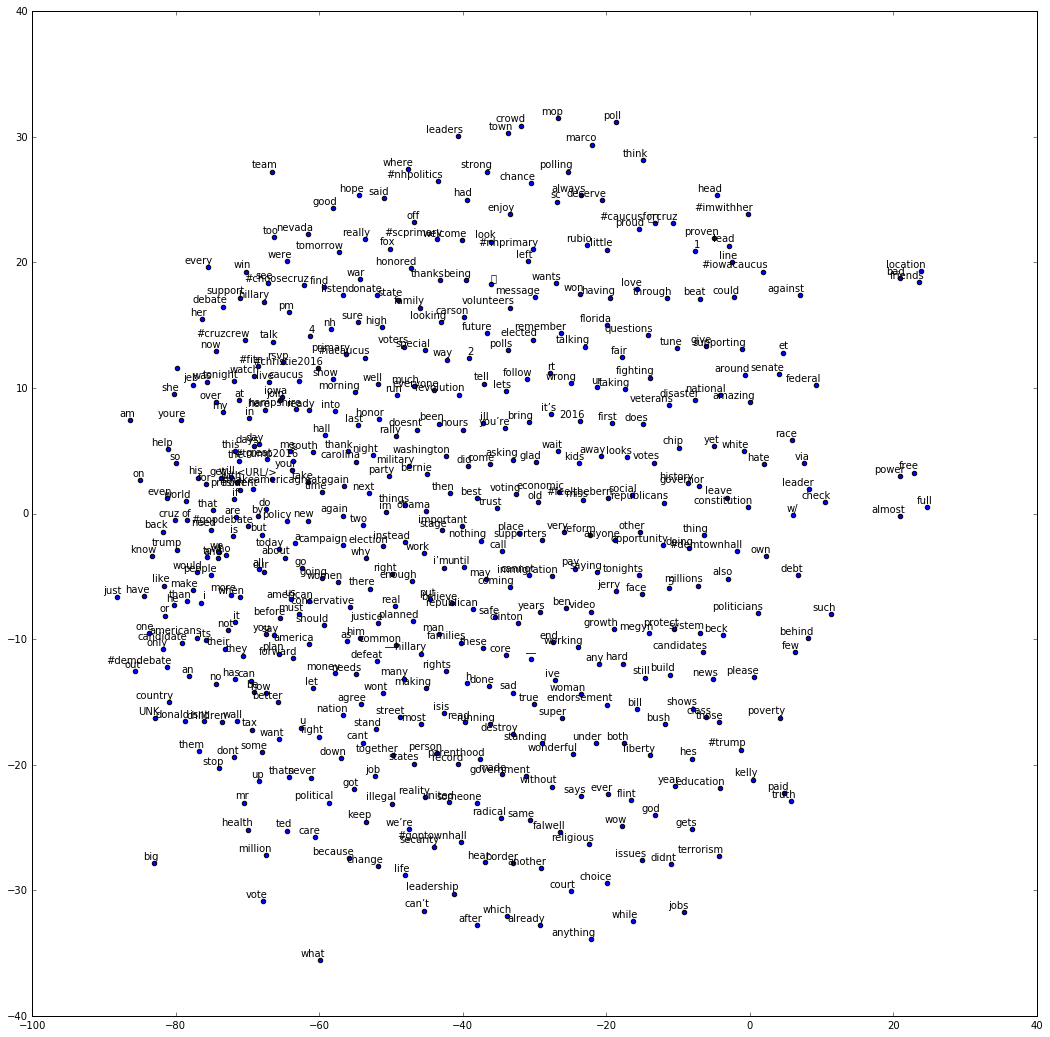

In [6]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig(filename)

get_ipython().magic(u'matplotlib inline')
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)

